## Mask Detection

After the broke out of COVID-19, wearing mask in public places became mandatory. But wearing mask could be inconvenient, which makes some people to not wearing it.

Our goal is to make a model that can determine whether the people in the image are wearing mask or not.

In [ ]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/contents')

Mounted at /contents


To determine people in the image are wearing mask or not, we need to detect human faces from the image. Haar Cascades is an object detection algorithm used to identify faces in an image or a real time video, which is commonly used for human face detection.

Download haarcascade_frontalface_default.xml from https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

In [ ]:
face_cascade = cv2.CascadeClassifier('/contents/MyDrive/yolov3/haarcascade_frontalface_default.xml')

In [ ]:
def image_show(idx, box=None, minNeighbors=5):
  imgpath = '/contents/MyDrive/yolov3/mask_detection/images/maksssksksss' + str(idx) + '.png'
  img = cv2.imread(imgpath)
  
  if box == 'detect':
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(img, minNeighbors=minNeighbors)
    
    for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y),(x+w, y+h), (0, 255, 0), 2)

  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  if box == 'annot':
    filepath = '/contents/MyDrive/yolov3/mask_detection/annotations/maksssksksss' + str(idx) + '.xml'
    tree = ET.parse(filepath)
    root = tree.getroot()

    infos = []
    for elem in root:
      if elem.tag == 'object':
        info = []
            
        for subelem in elem:
          if subelem.tag == 'name':
            mask = subelem.text
            code = {'without_mask':0, 'with_mask':1, 'mask_weared_incorrect':2}
            info.append(code[mask])
                      
          if subelem.tag == 'bndbox':
            for coord in subelem:
              info.append(int(coord.text))
        infos.append(info)
    
    for (mask, x, y, w, h) in infos:
      edgecolor = {0:(255,0,0), 1:(0,255,0), 2:(255,255,0)}
      cv2.rectangle(img,(x,y), (w,h), edgecolor[mask], 2)

  plt.imshow(img)

Image below is the labeled image.

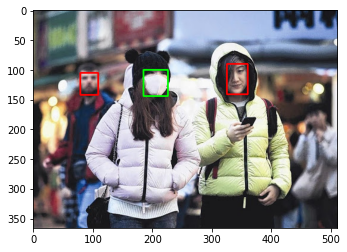

In [ ]:
image_show(0, box='annot')

Image below is the result of face detection by using Haar Cascades. It's doubtful that the model also works for people wearing mask. 

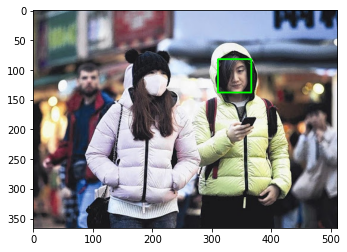

In [ ]:
image_show(0, box='detect')

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-24_at_12.52.19_PM_awcwYBa.png)

We can think of another way, building our own object detection model. 

YOLOv3 is one of the stood up model that is used for object detection. Our goal is to build mask detection model with YOLOv3.

You can download YOLOv3 by 

```
!git clone https://github.com/AlexeyAB/darknet .
```

In [ ]:
%cd /contents/MyDrive/yolov3/darknet

/contents/MyDrive/yolov3/darknet


In [ ]:
!nvidia-smi

Tue Oct 26 08:47:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    73W / 149W |     60MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv.cpp:1150:10: note: 

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3.weights

--2021-08-27 04:04:38--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  20.3MB/s    in 13s     

2021-08-27 04:04:52 (18.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
#!wget https://pjreddie.com/media/files/darknet53.conv.74

In [ ]:
!chmod +x ./darknet

In [ ]:
#!./darknet detector train data/face_mask.data cfg/face_mask.cfg backup/face_mask_last.weights -dont_show -i 0 -map -clear

In [ ]:
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
!./darknet detector test data/face_mask.data cfg/face_mask.cfg backup/face_mask_best.weights test/maksssksksss795.png
pred = 'predictions.jpg'

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,

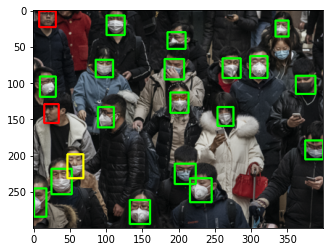

In [ ]:
image_show(795, 'annot')

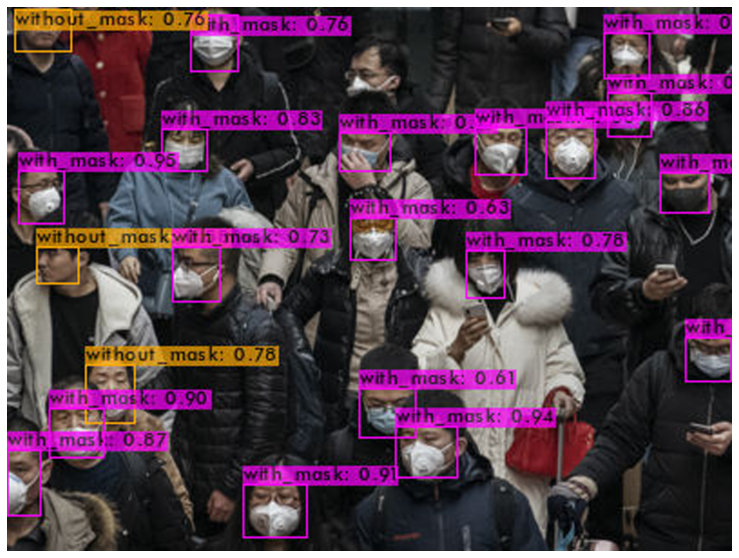

In [ ]:
imShow(pred)

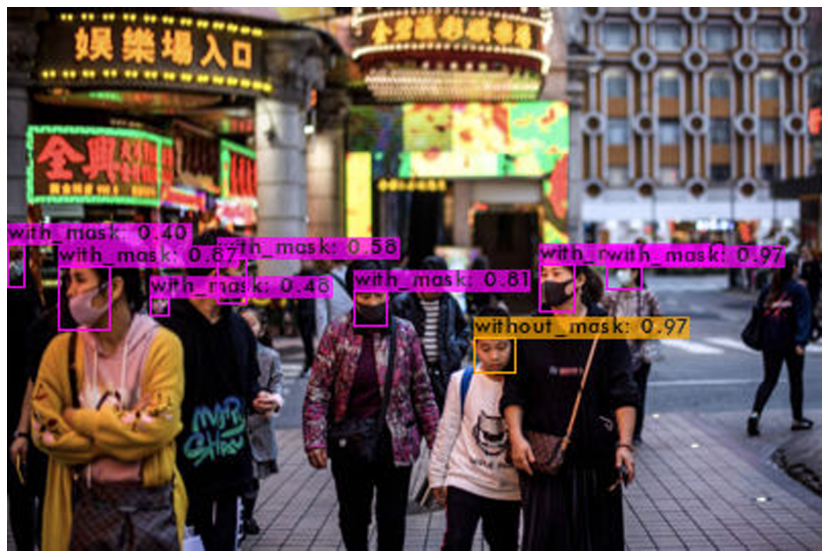

In [ ]:
imShow(pred)